## 成交量与未平仓量


In [32]:
import warnings
warnings.filterwarnings("ignore")

In [33]:
import pymongo
import pandas as pd
from datetime import datetime

In [34]:
symbolList = ['btc_usdt.spot:binance', 'eth_usdt.spot:binance', 'bnb_usdt.spot:binance', 'ltc_usdt.spot:binance','bch_usdt.spot:binance',
             'doge_usdt.spot:binance', 'matic_usdt.spot:binance', 'sol_usdt.spot:binance','link_usdt.spot:binance','uni_usdt.spot:binance']

client = pymongo.MongoClient('172.16.20.81', 27017)

In [35]:
def readDb(collection, start, end):
    return pd.DataFrame(
        list(collection.find({"datetime": {'$gt': start, '$lt': end}}))
    )

In [50]:
startTime = datetime(2022,6,25)
endTime = datetime(2023,1,2)
dbClient = client['Kline_1Min_Auto_Db_Plus']
columnsName = ['open', 'high', 'low', 'close', 'volume','datetime']

In [51]:
crytoDict = {
                'btc':readDb(dbClient[symbolList[0]], start=startTime , end=endTime)[columnsName],
                'eth':readDb(dbClient[symbolList[1]], start=startTime , end=endTime)[columnsName],
                'bnb':readDb(dbClient[symbolList[2]], start=startTime , end=endTime)[columnsName],
                'ltc':readDb(dbClient[symbolList[3]], start=startTime , end=endTime)[columnsName],
                'bch':readDb(dbClient[symbolList[4]], start=startTime , end=endTime)[columnsName],
                'doge':readDb(dbClient[symbolList[5]], start=startTime , end=endTime)[columnsName],
                'matic':readDb(dbClient[symbolList[6]], start=startTime , end=endTime)[columnsName],
                'sol':readDb(dbClient[symbolList[7]], start=startTime , end=endTime)[columnsName],
                'link':readDb(dbClient[symbolList[8]], start=startTime , end=endTime)[columnsName],
                'uni':readDb(dbClient[symbolList[9]], start=startTime , end=endTime)[columnsName],
            }

In [108]:
def resampleDf(data, freq='D'):
#     df = data.drop('_id', axis=1)
    dataDf = df.set_index('datetime')
    dataDf.resample(freq).agg({'open':'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume':'sum'})
    dataResetDf = dataDf.reset_index()
    return dataResetDf

In [109]:
def addSymbol(dataDf, symbolName):
    dataDf['symbol'] = symbolName
    return dataDf

In [110]:
def setIndex(dataDf):
    dataIndex = dataDf.set_index(['datetime', 'symbol'])
    return dataIndex

In [111]:
multiCryptoDict = {}
for key, df in crytoDict.items():
    hourDf = resampleDf(df)
    hourSymbolDf = addSymbol(hourDf, key)
    hourIndexDf = setIndex(hourSymbolDf)
    multiCryptoDict[key] = hourIndexDf

In [112]:
multiDf = pd.concat(list(multiCryptoDict.values())).sort_index()

In [113]:
multiDf

open         high         low       close  \
datetime            symbol                                                     
2022-06-25 00:01:00 bch       115.90000    116.00000    115.9000    115.9000   
                    bnb       235.10000    235.20000    234.9000    235.0000   
                    btc     20866.93000  20889.08000  20855.5100  20855.5100   
                    doge        0.06592      0.06598      0.0659      0.0659   
                    eth      1197.03000   1198.52000   1196.6400   1196.6400   
...                                 ...          ...         ...         ...   
2023-01-01 23:59:00 link        5.60000      5.60100      5.5950      5.5950   
                    ltc        70.38000     70.38000     70.3600     70.3600   
                    matic       0.75850      0.75860      0.7583      0.7585   
                    sol         9.85000      9.87000      9.8500      9.8700   
                    uni         5.21100      5.21100      5.2090      5.2090   

                                volume  
datetime            symbol              
2022-06-25 00:01:00 bch        238.435  
                    bnb        109.359  
                    btc         55.560  
                    doge    105517.000  
                    eth        417.678  
...                                ...  
2023-01-01 23:59:00 link       355.680  
                    ltc         57.204  
                    matic    15291.400  
                    sol       2606.350  
                    uni        227.990  

[2750390 rows x 5 columns]

In [114]:
shortPeriod = 7
longPeriod = shortPeriod*5

In [115]:
close = multiDf.close.unstack()
volume = multiDf.volume.unstack()

In [116]:
closeMaDiffNor = (close.rolling(shortPeriod).mean() - close.rolling(longPeriod).mean())/close.rolling(longPeriod).std()
volumeMaDiffNor = (volume.rolling(shortPeriod).mean() - volume.rolling(longPeriod).mean())/volume.rolling(longPeriod).std()

In [117]:
closeMaDiffNor

symbol,bch,bnb,btc,doge,eth,link,ltc,matic,sol,uni
datetime,,,,,,,,,,
2022-06-25 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-25 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-25 00:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-25 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-25 00:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-01-01 23:55:00,0.781004,-0.027944,0.627936,-0.602369,0.517147,0.715519,0.433524,0.542802,-0.027506,-0.833284
2023-01-01 23:56:00,0.919583,0.387509,0.749883,-0.607707,0.648041,0.797565,0.545659,0.608341,0.178376,-0.842544
2023-01-01 23:57:00,1.041241,0.680006,0.879913,-0.510008,0.776831,0.900871,0.618719,0.718459,0.478091,-1.017289


In [118]:
volumeMaDiffNor

symbol,bch,bnb,btc,doge,eth,link,ltc,matic,sol,uni
datetime,,,,,,,,,,
2022-06-25 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-25 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-25 00:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-25 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-25 00:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-01-01 23:55:00,-0.257786,0.435139,-0.187225,-0.397619,-0.661113,0.388200,-0.362115,-0.324764,0.380533,-0.023285
2023-01-01 23:56:00,-0.191534,0.701013,0.299941,-0.219203,-0.366840,0.628167,-0.286149,-0.082165,0.402329,0.022992
2023-01-01 23:57:00,-0.190294,0.698517,0.610166,-0.054608,-0.308185,0.774901,-0.296737,0.457365,0.759946,-0.028978


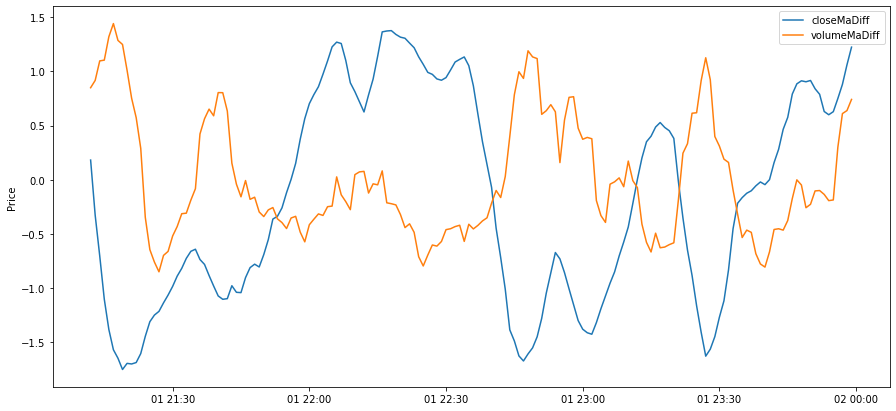

In [120]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 7))
plt.plot(closeMaDiffNor.btc.iloc[-168:])
plt.plot(volumeMaDiffNor.btc.iloc[-168:])
plt.ylabel('Price')
plt.legend(['closeMaDiff','volumeMaDiff'])
plt.show()